## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Subset, DataLoader

In [ ]:
%pip install git+https://github.com/RobustBench/robustbench
%pip install git+https://github.com/alirezaabdollahpour/SuperDeepFool.git
%pip install -q foolbox
%pip install tinyimagenet


  Cloning https://github.com/RobustBench/robustbench to /tmp/pip-req-build-go_2e_bi
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench /tmp/pip-req-build-go_2e_bi
  Resolved https://github.com/RobustBench/robustbench to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Using cached autoattack-0.1-py3-none-any.whl
  Cloning https://github.com/alirezaabdollahpour/SuperDeepFool.git to /tmp/pip-req-build-8m9omq5t
  Running command git clone --filter=blob:none --quiet https://github.com/alirezaabdollahpour/SuperDeepFool.git /tmp/pip-req-build-8m9omq5t
  Resolved https://github.com/alirezaabdollahpour/SuperDeepFool.git to commit 20f75b24a817309da73ea043e9f37dd80c07fa3f
  Preparing metadata (setup.py) ... done


In [ ]:
import robustbench
from robustbench import load_cifar10, load_model
import os
import logging
import math
import torch
import foolbox as fb
from tinyimagenet import TinyImageNet
import importlib
import numpy as np

In [ ]:
source_dir = "drive/MyDrive/Colab Notebooks/trustworthy/"

## Evaluator Class

In [ ]:
import math
import os

import foolbox as fb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from robustbench import load_cifar10
import kagglehub


class AttackEvaluator:
    def __init__(self, device) -> None:
        self.test_dataset = None
        self.test_loader = None
        self.class_names = None
        self.device = device
        if self.device is None:
            raise ValueError("Device cannot be None")
        self.images = None
        self.labels = None
        self.imagenet_path = None

    def load_dataset(self, dataset_type, batch_size=100):
        if dataset_type == "cifar10":
            torch.manual_seed(8)

            os.makedirs(os.path.join("data", "torchvision"), exist_ok=True)
            os.makedirs(os.path.join("results", "cifar10"), exist_ok=True)

            n_examples = 10000  # get all eval examples
            self.images, self.labels = load_cifar10(n_examples=n_examples, data_dir="data")
            self.test_dataset = torch.utils.data.TensorDataset(self.images, self.labels)
            self.test_loader = torch.utils.data.DataLoader(
                self.test_dataset, batch_size=batch_size, shuffle=False
            )
            self.class_names = [
                "airplane",
                "automobile",
                "bird",
                "cat",
                "deer",
                "dog",
                "frog",
                "horse",
                "ship",
                "truck",
            ]
            print(len(self.test_dataset))
        elif dataset_type == "imagenet":
            if not self.imagenet_path:
                self.imagenet_path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")
                self.imagenet_path = os.path.join(self.imagenet_path, "imagenet-mini", "val")

            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])
            full_dataset = torchvision.datasets.ImageFolder(self.imagenet_path, transform=transform)

            print(f"Found {len(full_dataset.classes)} classes.")

            n_examples = 5000
            indices = list(range(min(n_examples, len(full_dataset))))
            self.test_dataset = torch.utils.data.Subset(full_dataset, indices)

            temp_loader = torch.utils.data.DataLoader(
                self.test_dataset,
                batch_size=100,
                shuffle=False,
                num_workers=0
            )
            img_list = []
            label_list = []

            for x, y in temp_loader:
                img_list.append(x)
                label_list.append(y)
            self.images = torch.cat(img_list)
            self.labels = torch.cat(label_list)

            self.test_dataset = torch.utils.data.TensorDataset(self.images, self.labels)
            self.test_loader = torch.utils.data.DataLoader(
                self.test_dataset, batch_size=50, shuffle=False, num_workers=2
            )

            self.class_names = full_dataset.classes
            print(f"Loaded {len(self.test_dataset)} ImageNet examples.")
        else:
            raise ValueError("Incompatible dataset")

    def _per_class_accuracy(
        self,
        model: nn.Module,
        x: torch.Tensor,
        y: torch.Tensor,
        n_classes: int = 10,
        batch_size: int = 100,
    ):

        class_correct = torch.zeros(n_classes)
        class_total = torch.zeros(n_classes)

        n_batches = math.ceil(x.shape[0] / batch_size)
        with torch.no_grad():
            for counter in range(n_batches):
                x_curr = x[counter * batch_size : (counter + 1) * batch_size].to(
                    self.device
                )
                y_curr = y[counter * batch_size : (counter + 1) * batch_size].to(
                    self.device
                )

                output = model(x_curr)
                predictions = output.max(1)[1]

                for c in range(n_classes):
                    mask = y_curr == c
                    class_total[c] += mask.sum().item()
                    class_correct[c] += ((predictions == y_curr) & mask).sum().item()

        class_accuracies = class_correct / class_total
        overall_accuracy = class_correct.sum().item() / class_total.sum().item()

        return overall_accuracy, class_accuracies

    def eval_baseline(self, model, batch_size=100):
        acc_orig, per_class_orig = self._per_class_accuracy(model.to(self.device), self.images, self.labels, batch_size=batch_size)
        print(f"Overall Accuracy: {acc_orig:.4f}\n")
        print("Per-class Accuracy:")
        for i, (name, acc) in enumerate(zip(self.class_names, per_class_orig)):
                print(f"  {name:12s}: {acc:.4f}")

    def evaluate_robust_accuracy(
        self, fmodel, dataloader, attack_fn, attack_kwargs={}, eps=None
    ):
        robust_success_list = []
        adv_examples_list = []
        l_inf_list = []

        if callable(attack_fn):
            attack = attack_fn(**attack_kwargs)
        else:
            raise ValueError("attack_fn must be callable")

        for images, labels in dataloader:
            images = images.to(self.device)
            labels = labels.to(self.device)

            if eps is not None:
                _, clipped, success = attack(fmodel, images, labels, epsilons=[eps])
                clipped = clipped[0]
            else:
                _, clipped, success = attack(fmodel, images, labels)

            robust_success_list.append(success.float().reshape(-1).cpu())

            perturb = (clipped - images).detach().cpu()
            l_inf = perturb.abs().amax(dim=(1, 2, 3))
            l_inf_list.append(l_inf)

            # store adv imgs
            adv_examples_list.append(clipped.detach().cpu())

            # free GPU memory immediately
            del images, labels, perturb, clipped
            torch.cuda.empty_cache()

        # concatenate all batch results
        # print("Length of list:", len(adv_examples_list))
        robust_success = torch.cat(robust_success_list)
        robust_accuracy = 1 - robust_success.mean()
        l_inf_vals = torch.cat(l_inf_list, dim=0)
        adv_examples = torch.cat(adv_examples_list, dim=0)
        # print(adv_examples.shape)
        return robust_accuracy, robust_success, l_inf_vals, adv_examples

    def show_original_and_adv(self, idx, original_dataset, adv_image, adv_label=None):
        """
        original_dataset: dataset, tensor [N,C,H,W]
        adv_image: tensor [C,H,W]
        adv_label: integer (adversarial predicted class)
        """

        # detach
        original = original_dataset[idx][0].detach().cpu()
        adv = adv_image.detach()

        # Convert CHW -> HWC for matplotlib
        orig_img = original.permute(1, 2, 0).numpy()
        adv_img = adv.permute(1, 2, 0).numpy()


        # Build captions
        orig_title = "Original"
        label = original_dataset[idx][1]
        if label is not None and self.class_names is not None:
            orig_title += f"\n (label: {self.class_names[label]})"

        adv_title = "Adversarial"
        if adv_label is not None and self.class_names is not None:
            adv_title += f"\n (pred: {self.class_names[adv_label]})"

        # Plot
        plt.figure(figsize=(4, 2))

        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title(orig_title)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(adv_img)
        plt.title(adv_title)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    def plot_orig_adv(self, model, idx, adv_examples):
        adv_image = adv_examples[idx]
        with torch.no_grad():
            pred_adv = model(adv_image.unsqueeze(0).to(self.device)).argmax().item()
        self.show_original_and_adv(idx, self.test_dataset, adv_image, pred_adv)

## Load Datasets and Models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
att_eval_cifar = AttackEvaluator(device)
att_eval_imagenet = AttackEvaluator(device)
att_eval_cifar.load_dataset("cifar10", 128)
att_eval_imagenet.load_dataset("imagenet")

100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


10000


100%|██████████| 3.92G/3.92G [01:39<00:00, 42.4MB/s]

Extracting files...


Found 1000 classes.


In [ ]:
from robustbench.utils import rm_substr_from_state_dict, _safe_load_state_dict
from robustbench.model_zoo import model_dicts as all_models
from robustbench.model_zoo.enums import BenchmarkDataset, ThreatModel
def load_model_patched(model_name: str,
               custom_checkpoint,
               dataset = BenchmarkDataset.cifar_10,
               threat_model = 'Linf'):

    if dataset == 'imagenet':
      model = load_model(
          model_name=model_name,
          dataset='imagenet',
          threat_model='Linf'
      )
    else:
      dataset_: BenchmarkDataset = BenchmarkDataset(dataset)
      threat_model = ThreatModel('Linf').value.replace('_3d', '')
      threat_model_: ThreatModel = ThreatModel(threat_model)
      models = all_models[dataset_][threat_model_]
      # path to your uploaded checkpoint
      checkpoint = torch.load(custom_checkpoint, map_location=torch.device('cpu'), weights_only=False)

      model = models[model_name]['model']()
      state_dict = rm_substr_from_state_dict(checkpoint['state_dict'],'module.')
      model = _safe_load_state_dict(model, model_name, state_dict, dataset_)

    return model.eval()

base_model_path = os.path.join(source_dir, "natural.pt")
base_model = load_model_patched("Standard", base_model_path, 'cifar10')
base_fmodel = fb.PyTorchModel(base_model, bounds=(0, 1))

adversarial_model = load_model(model_name='Rade2021Helper_R18_ddpm', dataset='cifar10')
adversarial_fmodel = fb.PyTorchModel(adversarial_model, bounds=(0, 1))


# imagenet pretrained models
base_model_imagenet = load_model_patched("Standard_R50", None, 'imagenet')
base_fmodel_imagenet = fb.PyTorchModel(base_model_imagenet, bounds=(0, 1))

adversarial_model_imagenet = load_model_patched("Salman2020Do_R50", None, 'imagenet')
adversarial_fmodel_imagenet = fb.PyTorchModel(adversarial_model_imagenet, bounds=(0, 1))



Downloading...
From (original): https://drive.google.com/uc?id=1f2yJUo-jxCQNk589frzriv6wPyrQEZdX
From (redirected): https://drive.google.com/uc?id=1f2yJUo-jxCQNk589frzriv6wPyrQEZdX&confirm=t&uuid=30934988-fef6-408b-a499-1ae6356d1abc
To: /content/models/cifar10/Linf/Rade2021Helper_R18_ddpm.pt
100%|██████████| 50.3M/50.3M [00:00<00:00, 149MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1TmT5oGa1UvVjM3d-XeSj_XmKqBNRUg8r
From (redirected): https://drive.google.com/uc?id=1TmT5oGa1UvVjM3d-XeSj_XmKqBNRUg8r&confirm=t&uuid=dfe52580-93c9-4057-a7f7-b752b4ce85b8
To: /content/models/imagenet/Linf/Salman2020Do_R50.pt
100%|██████████| 103M/103M [00:00<00:00, 138MB/s] 


## Baselines

In [ ]:
att_eval_cifar.eval_baseline(base_model)
att_eval_cifar.eval_baseline(adversarial_model)
att_eval_imagenet.eval_baseline(base_model_imagenet)
att_eval_imagenet.eval_baseline(adversarial_model_imagenet)

Overall Accuracy: 0.9477

Per-class Accuracy:
  airplane    : 0.9680
  automobile  : 0.9760
  bird        : 0.9210
  cat         : 0.8780
  deer        : 0.9540
  dog         : 0.9260
  frog        : 0.9630
  horse       : 0.9610
  ship        : 0.9650
  truck       : 0.9650
Overall Accuracy: 0.8686

Per-class Accuracy:
  airplane    : 0.9000
  automobile  : 0.9500
  bird        : 0.7800
  cat         : 0.7420
  deer        : 0.8660
  dog         : 0.7600
  frog        : 0.9220
  horse       : 0.8980
  ship        : 0.9470
  truck       : 0.9210
Overall Accuracy: 0.8235

Per-class Accuracy:
  n01440764   : 1.0000
  n01443537   : 1.0000
  n01484850   : 1.0000
  n01491361   : 0.6667
  n01494475   : 0.6000
  n01496331   : 0.3333
  n01498041   : 1.0000
  n01514668   : 0.6667
  n01514859   : 1.0000
  n01518878   : 1.0000
Overall Accuracy: 0.7059

Per-class Accuracy:
  n01440764   : 0.6667
  n01443537   : 0.6667
  n01484850   : 0.8000
  n01491361   : 0.3333
  n01494475   : 0.6000
  n01496331

## PGD

In [ ]:
eps = 8 / 255
steps = 5
alpha = 0.033

In [ ]:
# CIFAR Base Model
base_robust_acc, base_rs, base_linf, base_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    base_fmodel, att_eval_cifar.test_loader,
    attack_fn=fb.attacks.LinfPGD,
    attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
    eps=eps
)
print(f"CIFAR Base Robust Accuracy: {base_robust_acc}")

CIFAR Base Robust Accuracy: 0.267799973487854


In [ ]:
# CIFAR Adversarial Model
adv_robust_acc, adv_rs, adv_linf, adv_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    adv_fmodel, att_eval_cifar.test_loader,
    attack_fn=fb.attacks.LinfPGD,
    attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
    eps=eps
)
print(f"CIFAR Adv Robust Accuracy: {adv_robust_acc}")

CIFAR Adv Robust Accuracy: 0.836400032043457


In [ ]:
# ImageNet Base Model
base_imagenet_robust_acc_, base_imagenet_rs, base_imagenet_linf, base_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
    base_fmodel_imagenet, att_eval_imagenet.test_loader,
    attack_fn=fb.attacks.LinfPGD,
    attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
    eps=eps
)
print(f"ImageNet Base Robust Accuracy: {base_imagenet_robust_acc_}")

ImageNet Base Robust Accuracy: 0.005353033542633057


In [ ]:
# ImageNet Adversarial Model
adv_imagenet_robust_acc, adv_imagenet_rs, adv_imagenet_linf, adv_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
    adv_fmodel_imagenet, att_eval_imagenet.test_loader,
    attack_fn=fb.attacks.LinfPGD,
    attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
    eps=eps
)
print(f"ImageNet Adv Robust Accuracy: {adv_imagenet_robust_acc}")


ImageNet Adv Robust Accuracy: 0.5720112323760986


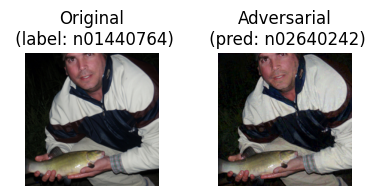

In [ ]:
adv_imagenet_rs
idx = 1
att_eval_imagenet.plot_orig_adv(adv_fmodel_imagenet, idx, adv_imagenet_adv_ex)

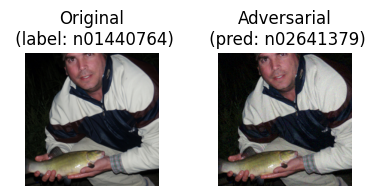

In [ ]:
base_imagenet_rs
idx = 1
att_eval_imagenet.plot_orig_adv(base_fmodel_imagenet, idx, base_imagenet_adv_ex)

### Ablation Study

#### Varying Epsilon

In [ ]:
eps_arr = [2/255, 4/255, 8/255, 12/255, 16/255]
alpha = 0.033
steps = 5

cifar_base_robust_accs = []
cifar_adv_robust_accs = []
imagenet_base_robust_accs = []
imagenet_adv_robust_accs = []

for eps in eps_arr:  # Simplified loop
    print(f'\n=== Epsilon: {eps:.4f} ({eps*255:.0f}/255) ===')

    # CIFAR Base Model
    base_robust_acc, base_rs, base_linf, base_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
        base_fmodel, att_eval_cifar.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    cifar_base_robust_accs.append(base_robust_acc)

    # CIFAR Adversarial Model
    adv_robust_acc, adv_rs, adv_linf, adv_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
        adv_fmodel, att_eval_cifar.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    cifar_adv_robust_accs.append(adv_robust_acc)

    # ImageNet Base Model
    base_imagenet_robust_acc, base_imagenet_rs, base_imagenet_linf, base_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
        base_fmodel_imagenet, att_eval_imagenet.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    imagenet_base_robust_accs.append(base_imagenet_robust_acc)

    # ImageNet Adversarial Model
    adv_imagenet_robust_acc, adv_imagenet_rs, adv_imagenet_linf, adv_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
        adv_fmodel_imagenet, att_eval_imagenet.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    imagenet_adv_robust_accs.append(adv_imagenet_robust_acc)



=== Epsilon: 0.0078 (2/255) ===

=== Epsilon: 0.0157 (4/255) ===

=== Epsilon: 0.0314 (8/255) ===

=== Epsilon: 0.0471 (12/255) ===

=== Epsilon: 0.0627 (16/255) ===


In [ ]:
print(f"{'Epsilon':<10} {'CIFAR Base':<12} {'CIFAR Adv':<12} {'ImgNet Base':<12} {'ImgNet Adv':<12}")

for i, eps in enumerate(eps_arr):
    # Prints Epsilon and 4 accuracies, all aligned with 3 decimal places
    print(f"{eps:<10.4f} "
          f"{cifar_base_robust_accs[i]:<12.3f} "
          f"{cifar_adv_robust_accs[i]:<12.3f} "
          f"{imagenet_base_robust_accs[i]:<12.3f} "
          f"{imagenet_adv_robust_accs[i]:<12.3f}")

Epsilon    CIFAR Base   CIFAR Adv    ImgNet Base  ImgNet Adv  
0.0078     0.812        0.861        0.207        0.633       
0.0157     0.593        0.854        0.051        0.611       
0.0314     0.263        0.837        0.005        0.573       
0.0471     0.109        0.817        0.002        0.529       
0.0627     0.045        0.794        0.001        0.478       


#### Varying number of steps

In [ ]:
eps = 8/255
alpha = 0.033
steps_arr = [2, 5, 10, 20, 40]

cifar_base_robust_accs2 = []
cifar_adv_robust_accs2 = []
imagenet_base_robust_accs2 = []
imagenet_adv_robust_accs2 = []

for steps in steps_arr:  # Simplified loop
    print(f'\n=== N Steps: {steps} ===')

    # CIFAR Base Model
    base_robust_acc, base_rs, base_linf, base_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
        base_fmodel, att_eval_cifar.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    cifar_base_robust_accs2.append(base_robust_acc)

    # CIFAR Adversarial Model
    adv_robust_acc, adv_rs, adv_linf, adv_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
        adv_fmodel, att_eval_cifar.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    cifar_adv_robust_accs2.append(adv_robust_acc)

    # ImageNet Base Model
    base_imagenet_robust_acc, base_imagenet_rs, base_imagenet_linf, base_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
        base_fmodel_imagenet, att_eval_imagenet.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    imagenet_base_robust_accs2.append(base_imagenet_robust_acc)

    # ImageNet Adversarial Model
    adv_imagenet_robust_acc, adv_imagenet_rs, adv_imagenet_linf, adv_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
        adv_fmodel_imagenet, att_eval_imagenet.test_loader,
        attack_fn=fb.attacks.LinfPGD,
        attack_kwargs={'steps': steps, 'rel_stepsize': alpha},
        eps=eps
    )
    imagenet_adv_robust_accs2.append(adv_imagenet_robust_acc)



=== N Steps: 2 ===

=== N Steps: 5 ===

=== N Steps: 10 ===

=== N Steps: 20 ===

=== N Steps: 40 ===


In [ ]:
print(f"{'Num Steps':<10} {'CIFAR Base':<12} {'CIFAR Adv':<12} {'ImgNet Base':<12} {'ImgNet Adv':<12}")

for i, steps in enumerate(steps_arr):
    # Prints Steps and 4 accuracies, all aligned with 3 decimal places
    print(f"{steps:<10} "
          f"{cifar_base_robust_accs2[i]:<12.3f} "
          f"{cifar_adv_robust_accs2[i]:<12.3f} "
          f"{imagenet_base_robust_accs2[i]:<12.3f} "
          f"{imagenet_adv_robust_accs2[i]:<12.3f}")

Num Steps  CIFAR Base   CIFAR Adv    ImgNet Base  ImgNet Adv  
2          0.632        0.854        0.116        0.618       
5          0.265        0.836        0.007        0.572       
10         0.064        0.805        0.001        0.500       
20         0.005        0.746        0.000        0.384       
40         0.000        0.654        0.000        0.243       


## DeepFool and SuperDeepFool

### Source Code

In [ ]:
# @title Attack
import time

class Attack(object):
    def __init__(self, name, model):

        self.attack = name
        self.model = model
        self.model_name = str(model).split("(")[0]
        self.device = next(model.parameters()).device

        self._attack_mode = 'default'
        self._targeted = False
        self._return_type = 'float'
        self._supported_mode = ['default']

        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, *input):
        raise NotImplementedError

    def get_mode(self):
        return self._attack_mode

    def set_mode_default(self):
        self._attack_mode = 'default'
        self._targeted = False
        print("Attack mode is changed to 'default.'")

    def set_mode_targeted_by_function(self, target_map_function=None):
        if "targeted" not in self._supported_mode:
            raise ValueError("Targeted mode is not supported.")

        self._attack_mode = 'targeted'
        self._targeted = True
        self._target_map_function = target_map_function
        print("Attack mode is changed to 'targeted.'")

    def set_mode_targeted_least_likely(self, kth_min=1):
        if "targeted" not in self._supported_mode:
            raise ValueError("Targeted mode is not supported.")

        self._attack_mode = "targeted(least-likely)"
        self._targeted = True
        assert (kth_min > 0)
        self._kth_min = kth_min
        self._target_map_function = self._get_least_likely_label
        print("Attack mode is changed to 'targeted(least-likely).'")

    def set_mode_targeted_random(self):
        r"""
        Set attack mode as targeted with random labels.
        Arguments:
            num_classses (str): number of classes.

        """
        if "targeted" not in self._supported_mode:
            raise ValueError("Targeted mode is not supported.")

        self._attack_mode = "targeted(random)"
        self._targeted = True
        self._target_map_function = self._get_random_target_label
        print("Attack mode is changed to 'targeted(random).'")

    def set_return_type(self, type):
        r"""
        Set the return type of adversarial images: `int` or `float`.

        Arguments:
            type (str): 'float' or 'int'. (Default: 'float')

        .. note::
            If 'int' is used for the return type, the file size of
            adversarial images can be reduced (about 1/4 for CIFAR10).
            However, if the attack originally outputs float adversarial images
            (e.g. using small step-size than 1/255), it might reduce the attack
            success rate of the attack.

        """
        if type == 'float':
            self._return_type = 'float'
        elif type == 'int':
            self._return_type = 'int'
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")

    def set_training_mode(self, model_training=False, batchnorm_training=False, dropout_training=False):
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False, save_pred=False):
        if save_path is not None:
            image_list = []
            label_list = []
            if save_pred:
                pre_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)

        given_training = self.model.training
        given_return_type = self._return_type
        self._return_type = 'float'

        for step, (images, labels) in enumerate(data_loader):
            start = time.time()
            adv_images = self.__call__(images, labels)

            batch_size = len(images)

            if verbose or return_verbose:
                with torch.no_grad():
                    if given_training:
                        self.model.eval()
                    outputs = self.model(adv_images)
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = (pred == labels.to(self.device))
                    correct += right_idx.sum()
                    end = time.time()
                    delta = (adv_images - images.to(self.device)).view(batch_size, -1)
                    l2_distance.append(torch.norm(delta[~right_idx], p=2, dim=1))

                    rob_acc = 100 * float(correct) / total
                    l2 = torch.cat(l2_distance).mean().item()
                    progress = (step+1)/total_batch*100
                    elapsed_time = end-start
                    if verbose:
                        self._save_print(progress, rob_acc, l2, elapsed_time, end='\r')

            if save_path is not None:
                if given_return_type == 'int':
                    adv_images = self._to_uint(adv_images.detach().cpu())
                    image_list.append(adv_images)
                else:
                    image_list.append(adv_images.detach().cpu())
                label_list.append(labels.detach().cpu())

                image_list_cat = torch.cat(image_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                if save_pred:
                    pre_list.append(pred.detach().cpu())
                    pre_list_cat = torch.cat(pre_list, 0)
                    torch.save((image_list_cat, label_list_cat, pre_list_cat), save_path)
                else:
                    torch.save((image_list_cat, label_list_cat), save_path)

        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end='\n')

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    def _save_print(self, progress, rob_acc, l2, elapsed_time, end):
        print('- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t' \
              % (progress, rob_acc, l2, elapsed_time), end=end)

    @torch.no_grad()
    def _get_target_label(self, images, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._targeted:
            given_training = self.model.training
            if given_training:
                self.model.eval()
            target_labels = self._target_map_function(images, labels)
            if given_training:
                self.model.train()
            return target_labels
        else:
            raise ValueError('Please define target_map_function.')

    @torch.no_grad()
    def _get_least_likely_label(self, images, labels=None):
        outputs = self.model(images)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def _get_random_target_label(self, images, labels=None):
        outputs = self.model(images)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l)*torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def _to_uint(self, images):
        r"""
        Function for changing the return type.
        Return images as int.
        """
        return (images*255).type(torch.uint8)

    def __str__(self):
        info = self.__dict__.copy()

        del_keys = ['model', 'attack']

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info['attack_mode'] = self._attack_mode
        info['return_type'] = self._return_type

        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"

    def __call__(self, *input, **kwargs):
        given_training = self.model.training

        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if 'BatchNorm' in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if 'Dropout' in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

        images = self.forward(*input, **kwargs)

        if given_training:
            self.model.train()

        if self._return_type == 'int':
            images = self._to_uint(images)

        return images

In [ ]:
# @title DeepFool
class DeepFool(Attack):
    r"""
    'DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks'
    [https://arxiv.org/abs/1511.04599]
    Distance Measure : L2
    Arguments:
        model (nn.Module): model to attack.
        steps (int): number of steps. (Default: 50)
        overshoot (float): parameter for enhancing the noise. (Default: 0.02)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model,
                 steps: int=100,
                 overshoot: float=0.02,
                 search_iter:int = 0,
                 number_of_samples = None):
        super().__init__("DeepFool", model)
        self.steps = steps
        self.overshoot = overshoot
        self.supported_mode = ['default']
        self.search_iter = search_iter
        self.number_of_samples = number_of_samples
        self.fool_checker = 0
        self.number_of_iterations = 0

    def forward(self, images, labels, return_target_labels=False, norm_p=2):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        batch_size = len(images)
        correct = torch.tensor([True]*batch_size)
        target_labels = labels.clone().detach().to(self.device)
        curr_steps = 0

        # adv_images = images.clone().detach().to(self.device)  # shape (batch_size, C, H, W)

        adv_images = []
        for idx in range(batch_size):
            image = images[idx:idx+1].clone().detach()
            adv_images.append(image)
        # adv_images = images.clone().detach().to(self.device)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                if not correct[idx]: continue
                early_stop, pre, adv_image = self._forward_indiv(adv_images[idx], labels[idx], norm_p)
                adv_images[idx] = adv_image
                target_labels[idx] = pre
                if early_stop:
                    correct[idx] = False
            curr_steps += 1

        self.number_of_iterations = curr_steps

        adv_images = torch.cat(adv_images).detach()

        if return_target_labels:

            return adv_images, target_labels

        return adv_images

    def _forward_indiv(self, image, label, norm_p=2):
        image.requires_grad = True
        fs = self.model(image)[0]
        _, pre = torch.max(fs, dim=0)
        if pre != label:
            return (True, pre, image)

        ws = self._construct_jacobian_parallel(fs, image)
        image = image.detach()

        f_0 = fs[label]
        w_0 = ws[label]

        wrong_classes = [i for i in range(len(fs)) if i != label]
        f_k = fs[wrong_classes]
        w_k = ws[wrong_classes]

        f_prime = f_k - f_0
        w_prime = w_k - w_0
        if norm_p == 2:
            value = torch.abs(f_prime) \
                    / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
            _, hat_L = torch.min(value, 0)

            delta = (torch.abs(f_prime[hat_L])*w_prime[hat_L] \
                    / ((torch.norm(w_prime[hat_L], p=2)**2)+1e-7))
        elif norm_p == "inf":
            value = torch.abs(f_prime) \
                    / torch.norm(nn.Flatten()(w_prime), p=1, dim=1)
            _, hat_L = torch.min(value, 0)

            delta = (torch.abs(f_prime[hat_L])*torch.sign(w_prime[hat_L]) \
                    / (torch.norm(w_prime[hat_L], p=1)+1e-7))
        else:
            raise ValueError("Unimplemented norm in DeepFool")

        target_label = hat_L if hat_L < label else hat_L+1

        adv_image = image + (1+self.overshoot)*delta
        adv_image = torch.clamp(adv_image, min=0, max=1).detach()
        return (False, target_label, adv_image)

    def _construct_jacobian(self, y, x):
        x_grads = []
        for idx, y_element in enumerate(y):
            if x.grad is not None:
                x.grad.zero_()
            y_element.backward(retain_graph=(False or idx+1 < len(y)))
            x_grads.append(x.grad.clone().detach())
        return torch.stack(x_grads).reshape(*y.shape, *x.shape)

    def _construct_jacobian_parallel(self, y, x):
        y = x.repeat(10, 1, 1, 1).detach().requires_grad_()
        out = self.model(y)
        out2 = out.diag().sum()
        out2.backward()
        return y.grad

In [ ]:
# @title SuperDeepFool
class SuperDeepFool(Attack):
    def __init__(
        self,
        model,
        steps: int = 100,
        overshoot: float = 0.02,
        search_iter: int = 0,
        number_of_samples=None,
        l_norm: str = "L2",
    ):
        super().__init__("SuperDeepFool", model)
        self.steps = steps
        self.overshoot = overshoot
        self.deepfool = DeepFool(
            model, steps=steps, overshoot=overshoot, search_iter=10
        )
        self._supported_mode = ["default"]
        self.search_iter = search_iter
        self.number_of_samples = number_of_samples
        self.fool_checker = 0
        # self.l_norm = l_norm
        self.target_label = None

    def forward(self, images, labels, norm_p=2, verbose: bool = True):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        batch_size = len(images)
        correct = torch.tensor([True] * batch_size)
        curr_steps = 0

        # FIX 1: Initialize as a Tensor, not a List
        adv_images = images.clone().detach()
        r_tot = torch.zeros_like(images)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                if not correct[idx]: continue # Optimization: Skip already fooled images

                # FIX 2: Use slicing [idx:idx+1] to keep the 4D shape [1, C, H, W]
                image = images[idx : idx + 1]
                label = labels[idx : idx + 1]
                r_ = r_tot[idx : idx + 1]

                # This ensures we pass a 4D tensor to DeepFool
                current_adv_image = adv_images[idx : idx + 1]

                fs = self.model(current_adv_image)[0]
                _, pre = torch.max(fs, dim=0)
                if pre != label:
                    correct[idx] = False
                    continue

                # Now DeepFool receives 1 image and 1 label. Safe.
                adv_image_Deepfool, target_label = self.deepfool(
                    current_adv_image, label, return_target_labels=True, norm_p=norm_p
                )

                r_i = adv_image_Deepfool - image

                # Important: Detach here to avoid graph accumulation issues in loop
                adv_image_Deepfool = adv_image_Deepfool.detach()
                adv_image_Deepfool.requires_grad = True

                fs = self.model(adv_image_Deepfool)[0]
                _, pre = torch.max(fs, dim=0)

                if pre == label:
                    pre = target_label
                cost = fs[pre] - fs[label]

                last_grad = torch.autograd.grad(
                    cost, adv_image_Deepfool, retain_graph=False, create_graph=False
                )[0]

                if self.l_norm == "L2":
                    last_grad = last_grad / last_grad.norm()
                    # Fix: Ensure last_grad matches r_ shape for broadcasting
                    r_ = (
                        r_
                        + (last_grad * (r_i)).sum()
                        * last_grad
                        / (
                            np.linalg.norm(
                                last_grad.detach().cpu().numpy().flatten(), ord=2
                            )
                        )
                        ** 2
                    )

                current_adv_image = image + r_

                # FIX 3: Assign back to the slice to handle 4D assignment
                adv_images[idx : idx + 1] = current_adv_image.detach()
                r_tot[idx : idx + 1] = r_.detach()
                self.target_label = target_label.detach()

            curr_steps += 1

        # No need to cat, adv_images is already a tensor
        if self.search_iter > 0:
            if verbose:
                print(f"search iteration for SuperDeepfool -> {self.search_iter}")
            dx = adv_images - images
            dx_l_low, dx_l_high = torch.zeros_like(dx), torch.ones_like(dx)
            for i in range(self.search_iter):
                dx_l = (dx_l_low + dx_l_high) / 2.0
                dx_x = images + dx_l * dx
                dx_y = self.model(dx_x).argmax(-1)
                label_stay = dx_y == labels
                label_change = dx_y != labels

                # Ensure masking works with proper shapes
                # If label_stay is 1D, we might need to unsqueeze for broadcasting
                if label_stay.dim() == 1:
                    label_stay = label_stay.view(-1, 1, 1, 1)
                if label_change.dim() == 1:
                    label_change = label_change.view(-1, 1, 1, 1)

                dx_l_low = torch.where(label_stay, dx_l, dx_l_low)
                dx_l_high = torch.where(label_change, dx_l, dx_l_high)

            adv_images = images + dx_l_high * dx

        return adv_images

In [ ]:
class DFWrapper:
    def __init__(self, df, norm_p=2):
        self.df = df
        self.norm_p = norm_p

    def __call__(self, fmodel, images, labels):
        adv_images = self.df.forward(images, labels, norm_p=self.norm_p)
        with torch.no_grad():
            logits = fmodel(adv_images)
            preds = logits.argmax(dim=1)
            success_manual = (preds != labels).float()  # 1.0 if attack fooled model
        clipped_adv = torch.clamp(adv_images, 0.0, 1.0)
        return adv_images, clipped_adv, success_manual

class SDFWrapper:
    def __init__(self, sdf, norm_p=2):
        self.sdf = sdf
        self.norm_p = norm_p

    def __call__(self, fmodel, images, labels):
        adv_images = self.sdf.forward(images, labels, norm_p=self.norm_p)
        with torch.no_grad():
            logits = fmodel(adv_images)
            preds = logits.argmax(dim=1)
            success_manual = (preds != labels).float()  # 1.0 if attack fooled model
        clipped_adv = torch.clamp(adv_images, 0.0, 1.0)
        return adv_images, clipped_adv, success_manual


### Experiments

#### DeepFool

In [ ]:
PYTORCH_CUDA_ALLOC_CONF=True

In [ ]:
from torch.utils.data import Subset, DataLoader

n_examples_subset = 1000  # choose how many samples you want

subset_dataset_cifar = Subset(att_eval_cifar.test_loader.dataset, range(n_examples_subset))
subset_loader_cifar = DataLoader(subset_dataset_cifar, batch_size=16, shuffle=False)

df_baseline_cifar = DeepFool(base_model, steps=5)
df_baseline_cifar_attack = DFWrapper(df_baseline_cifar)
df_base_cifar_robust_acc, df_base_cifar_rs, df_base_cifar_linf, df_base_cifar_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    base_fmodel, subset_loader_cifar,
    attack_fn=DFWrapper,
    attack_kwargs={"df": df_baseline_cifar}
)


# NEXT MODEL
df_adversarial_cifar = DeepFool(adversarial_model, steps=5)
df_adversarial_cifar_attack = DFWrapper(df_adversarial_cifar)
df_adversarial_cifar_robust_acc, df_adversarial_cifar_rs, df_adversarial_cifar_linf, df_adversarial_cifar_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    adversarial_fmodel, subset_loader_cifar,
    attack_fn=DFWrapper,
    attack_kwargs={"df": df_adversarial_cifar}
)




In [ ]:

subset_dataset_imagenet = Subset(att_eval_imagenet.test_loader.dataset, range(n_examples_subset))
subset_loader_imagenet = DataLoader(subset_dataset_imagenet, batch_size=16, shuffle=False)

df_baseline_imagenet = DeepFool(base_model_imagenet, steps=5)
df_baseline_imagenet_attack = DFWrapper(df_baseline_imagenet)
df_base_imagenet_robust_acc, df_base_imagenet_rs, df_base_imagenet_linf, df_base_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
    base_fmodel_imagenet, subset_loader_imagenet,
    attack_fn=DFWrapper,
    attack_kwargs={"df": df_baseline_imagenet}
)

df_adversarial_imagenet = DeepFool(adversarial_model_imagenet, steps=5)
df_adversarial_imagenet_attack = DFWrapper(df_adversarial_imagenet)
df_adversarial_imagenet_robust_acc, df_adversarial_imagenet_rs, df_adversarial_imagenet_linf, df_adversarial_imagenet_adv_ex = att_eval_imagenet.evaluate_robust_accuracy(
    adversarial_fmodel_imagenet, subset_loader_imagenet,
    attack_fn=DFWrapper,
    attack_kwargs={"df": df_adversarial_imagenet}
)



NameError: name 'Subset' is not defined

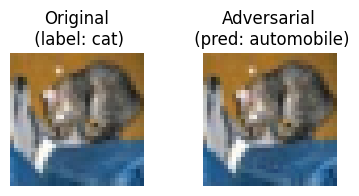

robust acc: 0.14800000190734863, 0.021723464131355286


In [ ]:
df_base_idx_cifar = 0
att_eval_cifar.plot_orig_adv(base_fmodel, df_base_idx_cifar, df_base_cifar_adv_ex)
print(f"robust acc: {df_base_cifar_robust_acc}, {torch.median(df_base_cifar_linf)}") # how much image had to be perturbed

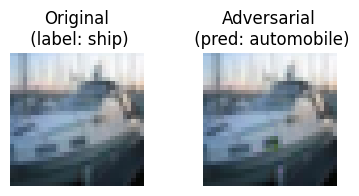

robust acc: (tensor(0.0310), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.,

In [ ]:
df_adversarial_idx_cifar = 2
att_eval_cifar.plot_orig_adv(adversarial_fmodel, df_adversarial_idx_cifar, df_adversarial_cifar_adv_ex)
print(f"robust acc: {df_adversarial_cifar_robust_acc, df_adversarial_cifar_rs} {torch.median(df_adversarial_cifar_linf)}")

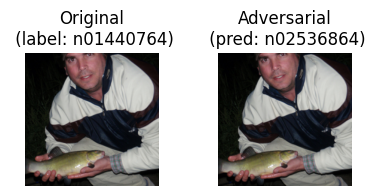

tensor(0.2790) tensor(0.0056)


In [ ]:

df_base_idx_imagenet = 1
att_eval_imagenet.plot_orig_adv(base_fmodel_imagenet, df_base_idx_imagenet, df_base_imagenet_adv_ex)
print(df_base_imagenet_robust_acc, torch.median(df_base_imagenet_linf))

# df_adversarial_idx_imagenet = 1
# att_eval_imagenet.plot_orig_adv(adversarial_fmodel_imagenet, df_adversarial_idx_imagenet, df_base_cifar_adv_ex)

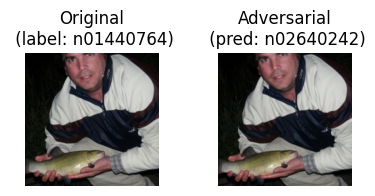

tensor(0.1860) tensor(0.1541)


In [ ]:
df_adversarial_idx_imagenet = 1
att_eval_imagenet.plot_orig_adv(adversarial_fmodel_imagenet,df_adversarial_idx_imagenet, df_adversarial_imagenet_adv_ex)
print(df_adversarial_imagenet_robust_acc, torch.median(df_adversarial_imagenet_linf))

In [ ]:
from torch.utils.data import Subset, DataLoader

n_examples_subset = 1000  # choose how many samples you want

subset_dataset_cifar = Subset(att_eval_cifar.test_loader.dataset, range(n_examples_subset))
subset_loader_cifar = DataLoader(subset_dataset_cifar, batch_size=16, shuffle=False)

df_baseline_cifar2 = DeepFool(base_model, steps=5)
df_base_cifar_robust_acc2, df_base_cifar_rs2, df_base_cifar_linf2, df_base_cifar_adv_ex2 = att_eval_cifar.evaluate_robust_accuracy(
    base_fmodel, subset_loader_cifar,
    attack_fn=DFWrapper,
    attack_kwargs={"df": df_baseline_cifar2, "norm_p": "inf"}
)


# NEXT MODEL
df_adversarial_cifar2 = DeepFool(adversarial_model, steps=5)
df_adversarial_cifar_robust_acc2, df_adversarial_cifar_rs2, df_adversarial_cifar_linf2, df_adversarial_cifar_adv_ex2 = att_eval_cifar.evaluate_robust_accuracy(
    adversarial_fmodel, subset_loader_cifar,
    attack_fn=DFWrapper,
    attack_kwargs={"df": df_adversarial_cifar2, "norm_p": "inf"}
)




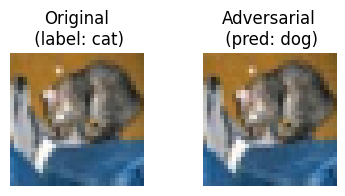

robust acc: 0.10199999809265137, 0.005009680986404419


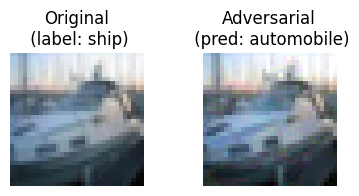

robust acc: (tensor(0.0290), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.,

In [ ]:
df_base_idx_cifar2 = 0
att_eval_cifar.plot_orig_adv(base_fmodel, df_base_idx_cifar2, df_base_cifar_adv_ex2)
print(f"robust acc: {df_base_cifar_robust_acc2}, {torch.median(df_base_cifar_linf2)}") # how much image had to be perturbed

df_adversarial_idx_cifar2 = 2
att_eval_cifar.plot_orig_adv(adversarial_fmodel, df_adversarial_idx_cifar2, df_adversarial_cifar_adv_ex2)
print(f"robust acc: {df_adversarial_cifar_robust_acc2, df_adversarial_cifar_rs2} {torch.median(df_adversarial_cifar_linf2)}")

In [ ]:
from torch.utils.data import Subset, DataLoader

n_examples_subset = 100  # choose how many samples you want

subset_dataset = Subset(att_eval_cifar.test_loader.dataset, range(n_examples_subset))
subset_loader = DataLoader(subset_dataset, batch_size=16, shuffle=False)

In [ ]:
sdf = SuperDeepFool(base_model, steps=5)
sdf_attack = SDFWrapper(sdf)
sdf_base_robust_acc, sdf_base_rs, sdf_base_linf, sdf_base_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    base_fmodel, att_eval_cifar.test_loader, #or subset_loader
    attack_fn=SDFWrapper,
    attack_kwargs={"sdf": sdf}
)

#### SuperDeepFool

In [ ]:
from torch.utils.data import Subset, DataLoader

n_examples_subset = 1000  # choose how many samples you want

subset_dataset_cifar = Subset(att_eval_cifar.test_loader.dataset, range(n_examples_subset))
subset_loader_cifar = DataLoader(subset_dataset_cifar, batch_size=64, shuffle=False)

# subset_dataset_imagenet = Subset(att_eval_imagenet.test_loader.dataset, range(n_examples_subset))
# subset_loader_imagenet = DataLoader(subset_dataset_imagenet, batch_size=8, shuffle=False)

In [ ]:
all_data = {"cifar_base": {}, "cifar_adv": {}, "imagenet_base": {}, "imagenet_adv": {}}

In [ ]:
sdf = SuperDeepFool(base_model, steps=100)

In [ ]:
# cifar base model
sdf_robust_acc, sdf_rs, sdf_linf, sdf_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    base_fmodel, subset_loader_cifar,
    attack_fn=SDFWrapper,
    attack_kwargs={"sdf": sdf, "norm_p": 2}
)
all_data["cifar_base"] = {"robust_acc": sdf_robust_acc,
                          "robust_suc": sdf_rs,
                          "linf": sdf_linf,
                          "adv_ex": sdf_adv_ex}

Robust accuracy:  tensor(0.0010)


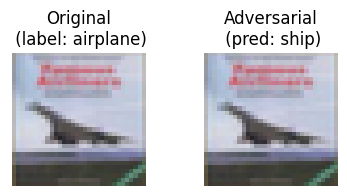

In [ ]:
print("Robust accuracy: ", all_data["cifar_base"]["robust_acc"])
idx = 3
att_eval_cifar.plot_orig_adv(base_fmodel, idx, all_data["cifar_base"]["adv_ex"])

In [ ]:
torch.median(all_data["cifar_base"]["linf"])

tensor(0.0204)

In [ ]:
sdf_robust_acc, sdf_rs, sdf_linf, sdf_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    adv_fmodel, subset_loader_cifar,
    attack_fn=SDFWrapper,
    attack_kwargs={"sdf": SuperDeepFool(adv_model, steps=100), "norm_p": 2}
)
all_data["cifar_adv"] = {"robust_acc": sdf_robust_acc,
                          "robust_suc": sdf_rs,
                          "linf": sdf_linf,
                          "adv_ex": sdf_adv_ex}

Robust accuracy:  tensor(0.)


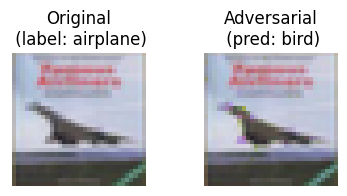

tensor(0.3349)

In [ ]:
print("Robust accuracy: ", all_data["cifar_adv"]["robust_acc"])
idx = 3
att_eval_cifar.plot_orig_adv(base_fmodel, idx, all_data["cifar_adv"]["adv_ex"])
torch.median(all_data["cifar_adv"]["linf"])

In [ ]:
# cifar base model, linf
sdf_robust_acc, sdf_rs, sdf_linf, sdf_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    base_fmodel, subset_loader_cifar,
    attack_fn=SDFWrapper,
    attack_kwargs={"sdf": SuperDeepFool(base_model, steps=100), "norm_p": "inf"}
)
all_data["cifar_base_linf"] = {"robust_acc": sdf_robust_acc,
                          "robust_suc": sdf_rs,
                          "linf": sdf_linf,
                          "adv_ex": sdf_adv_ex}

robust accuracy:  tensor(0.0010)


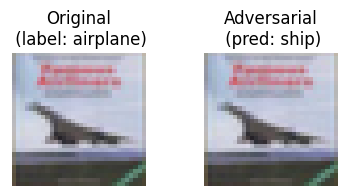

tensor(0.0203)

In [ ]:
print("robust accuracy: ", all_data["cifar_base_linf"]["robust_acc"])
idx = 3
att_eval_cifar.plot_orig_adv(base_fmodel, idx, all_data["cifar_base_linf"]["adv_ex"])
torch.median(all_data["cifar_base_linf"]["linf"])

In [ ]:
sdf_robust_acc, sdf_rs, sdf_linf, sdf_adv_ex = att_eval_cifar.evaluate_robust_accuracy(
    adv_fmodel, subset_loader_cifar,
    attack_fn=SDFWrapper,
    attack_kwargs={"sdf": SuperDeepFool(adv_model, steps=100), "norm_p": "inf"}
)
all_data["cifar_adv_linf"] = {"robust_acc": sdf_robust_acc,
                          "robust_suc": sdf_rs,
                          "linf": sdf_linf,
                          "adv_ex": sdf_adv_ex}

robust accuracy:  tensor(0.0040)


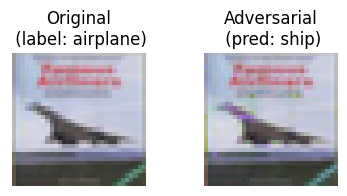

tensor(0.3169)

In [ ]:
print("robust accuracy: ", all_data["cifar_adv_linf"]["robust_acc"])
idx = 3
att_eval_cifar.plot_orig_adv(adv_fmodel, idx, all_data["cifar_adv_linf"]["adv_ex"])
torch.median(all_data["cifar_adv_linf"]["linf"])

In [ ]:
from torch.utils.data import Subset, DataLoader

small_test_dataset = Subset(test_dataset, list(range(20)))
small_test_loader = DataLoader(small_test_dataset, batch_size=15, shuffle=False)
acc, success, l_inf_vals, adv_examples = evaluate_robust_accuracy(base_fmodel, small_test_loader, alpha, 1)
print(acc)

In [ ]:
idx = 2
plot_orig_adv(base_fmodel, idx, adv_examples)